In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


from mpl_toolkits import mplot3d
from torch.distributions import multivariate_normal

%matplotlib inline

In [2]:
# параметры распределений

mu0, sigma0 = -2, 1
mu1, sigma1 = 3, 2

mu0_x, mu0_y, sigma0_x, sigma0_y = -2, -2, 1, 1
mu1_x, mu1_y, sigma1_x, sigma1_y = 3, 3, 2, 2

In [3]:
def multi_sample(multi_d0, multi_d1, n=32):
    x0 = multi_d0.sample([n])
    y0 = torch.zeros((n, 1))
    
    x1 = multi_d1.sample([n])
    y1 = torch.ones((n, 1))
    
    return torch.cat( [x0, x1], 0 ), torch.cat( [y0, y1], 0 )

In [4]:
mus_0 = torch.tensor([ mu0_x, mu0_y ], dtype=torch.float32)
cov_matrix_0 = torch.tensor([
    [sigma0_x ** 2, 0], 
    [0, sigma0_y ** 2]
], dtype=torch.float32)
multi_d0 = multivariate_normal.MultivariateNormal(mus_0, covariance_matrix=cov_matrix_0)


mus_1 = torch.tensor([ mu1_x, mu1_y ], dtype=torch.float32)
cov_matrix_1 = torch.tensor([
    [sigma1_x ** 2, 0], 
    [0, sigma1_y ** 2]
], dtype=torch.float32)
multi_d1 = multivariate_normal.MultivariateNormal(mus_1, covariance_matrix=cov_matrix_1)

In [5]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.4336, -0.5326]), tensor(-0.2373)]


In [6]:
log_freq = 500
for i in range(50000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = multi_sample(multi_d0, multi_d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = multi_sample(multi_d0, multi_d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 2.565856
Ошибка после 1 итераций: 0.323481
Ошибка после 2 итераций: 0.171837
Ошибка после 3 итераций: 0.126839
Ошибка после 4 итераций: 0.104995
Ошибка после 5 итераций: 0.091191
Ошибка после 6 итераций: 0.082407
Ошибка после 7 итераций: 0.076079
Ошибка после 8 итераций: 0.070087
Ошибка после 9 итераций: 0.066958
Ошибка после 10 итераций: 0.063167
Ошибка после 11 итераций: 0.060220
Ошибка после 12 итераций: 0.058457
Ошибка после 13 итераций: 0.056145
Ошибка после 14 итераций: 0.055179
Ошибка после 15 итераций: 0.053158
Ошибка после 16 итераций: 0.051640
Ошибка после 17 итераций: 0.050257
Ошибка после 18 итераций: 0.049440
Ошибка после 19 итераций: 0.048428
Ошибка после 20 итераций: 0.047775
Ошибка после 21 итераций: 0.046972
Ошибка после 22 итераций: 0.046321
Ошибка после 23 итераций: 0.044968
Ошибка после 24 итераций: 0.045080
Ошибка после 25 итераций: 0.044357
Ошибка после 26 итераций: 0.044063
Ошибка после 27 итераций: 0.043256
Ошибка после 28 итераций: 0.04

In [7]:
width = 200

x_scale = np.linspace(-10, 10, width)
y_scale = np.linspace(-10, 10, width)

X, Y = np.meshgrid(x_scale, y_scale)

points = np.stack([X, Y], axis=2)
xy_tensor = torch.tensor(points, dtype=torch.float)
with torch.no_grad():
    predictions = torch.sigmoid(layer(xy_tensor)).reshape([width, width]).numpy()

d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)

D0_l, D0_r = np.meshgrid( d0_pdf, d0_pdf )
D0 = D0_l * D0_r

D1_l, D1_r = np.meshgrid( d1_pdf, d1_pdf )
D1 = D1_l * D1_r

R = D1 / (D0 + D1)

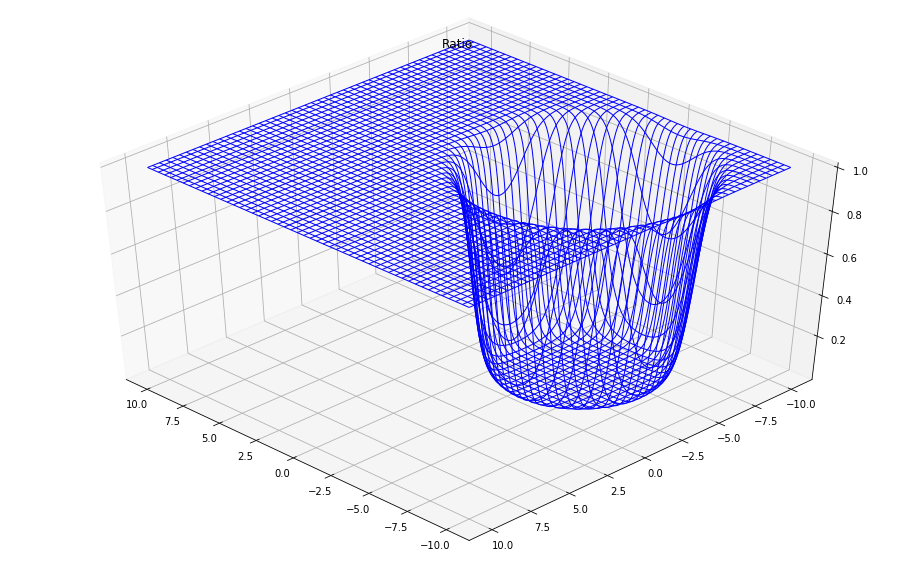

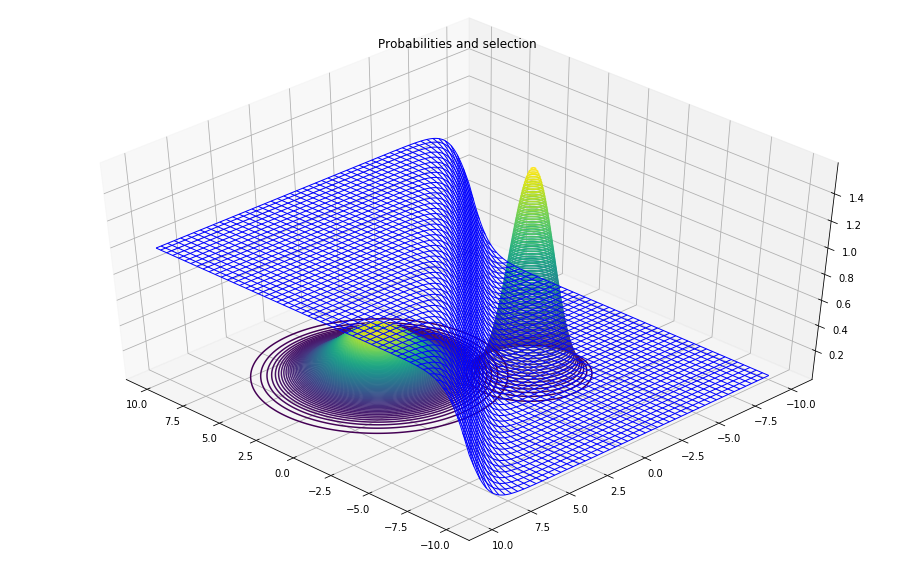

In [8]:
plt.figure(figsize=(16, 10))

ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, R, 1, color='blue')
ax.set_title('Ratio')

ax.view_init(45, 135)
plt.show()

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, predictions, 1, color='blue')
ax.contour3D(X, Y, D1 * 10, 100, cmap='viridis')
ax.contour3D(X, Y, D0 * 10, 100, cmap='viridis')
ax.set_title('Probabilities and selection')

ax.view_init(45, 135)

plt.show()